In [2]:
#导入相关的库
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time
import datetime
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from scipy import sparse
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
np.set_printoptions(suppress=True)  # 取消科学技术法
import pickle

In [3]:
# 加载数据
train = pd.read_table('F:/BaiduNetdiskDownload/adevertisment/gxs/round1_iflyad_train.txt')
test = pd.read_table('F:/BaiduNetdiskDownload/adevertisment/gxs/round1_iflyad_test_feature.txt')

# 合并训练集，测试集
data = pd.concat([train,test],axis=0,ignore_index=True)
data['click'] = data['click'].fillna(-1)

In [27]:
data.head()

,adid,advert_id,advert_industry_inner,advert_name,app_cate_id,app_id,app_paid,campaign_id,carrier,city,click,creative_has_deeplink,creative_height,creative_id,creative_is_download,creative_is_js,creative_is_jump,creative_is_voicead,creative_tp_dnf,creative_type,creative_width,devtype,f_channel,inner_slot_id,instance_id,make,model,nnt,orderid,os,os_name,osv,province,time,user_tags
0,1560128,230000063,102400_102401,B4734117F35EE97F,107.0,2089229.0,False,1000023,1,137103102105100,0.0,False,720,2338420,False,False,True,False,8390267734059046014,8,1280,2,NaN,xf_275C061483984E075832A4373BDDF27B,86294719979897807,HUAWEI,HUAWEI-CAZ-AL10,1,3010798,2,android,7.0.0,137103102100100,2190219034,NaN
1,1488859,230000063,102400_102401,B4734117F35EE97F,108.0,2070079.0,False,1000023,3,137105101100100,0.0,False,640,2310417,False,False,True,False,8390208550469153745,8,960,2,NaN,xf_D84DAB691E2E08C5B80D2FF5135F886E,2699289844928136052,Xiaomi,Redmi Note 4,1,2311397,2,android,6.0,137105101100100,2190221070,"2100191,2100078,3001825,,3001781,3001791,3001795,3001799,3001955,3002047,3002071,3002095,3002169,3002265,3002311,3002315,3002329,3002347,3002493,3002559,3002573,3002613,3002633,3002677,3002685,3002753,3002847,3002849,3002901,3002903,3003055,3003141,3003147,3003255,3003261,3003313,3003321,3003349,3003323,3003379,3003389,3003417,,3003443,3003457,3003489,3003509,3003537,3003559,3003575,3003605,3003635,3003679,3003703,3003709,3003715,3003727,3003745,3003747,3003769,3003779,3003819,3003841,300384..."
2,1537089,230000065,101700_101704,E257895F74792E81,100.0,2089397.0,False,1000021,3,137103104111100,0.0,False,640,2337017,False,False,True,False,8390430283595430291,8,960,2,NaN,xf_7F9FF3BEA11FE5B3AE6332EFBBD59496,3117527168445845752,OPPO,OPPO+R11s,1,3008491,2,android,7.1.1,137103104100100,2190219793,NaN
3,1577884,230001710,101900_101902,0A421D7B11EABFC5,100.0,2071234.0,False,1003544,0,137103102113100,0.0,False,720,2342152,False,False,True,False,8390229093704413749,3,1280,2,iqy_2,iqy_1000000000381-1-15-15,3398484891050993371,NaN,OPPO A57,1,3011304,2,android,6.0.1,137103102100100,2190221704,"2100098,gd_2100000,3001791,3001795,3002193,3002329,3002559,3002749,3002747,3003379,3003509,3003537,3003559,3003659,3003679,3003715,3003779,,3003843,3003851,3003863,3003865,3003869,3003875,3003939,3004059,3004081,3004089,3004093,3004095,3004147,3004149,3004153,3004224,3004214,3004256,3004258,3004262,3004266,3004430,3004434,3004500,3004506"
4,1432367,230000063,102400_102401,B4734117F35EE97F,103.0,1030051.0,False,1000023,1,137103102109100,0.0,False,640,2305409,False,False,True,False,8390208550469153745,8,960,2,NaN,xf_6C4DCB36DBE7EB12CE55EDF319FF8D93,2035477570591176488,Apple,iPhone 7,3,2304491,1,ios,11.1.1,137103102100100,2190220024,NaN


##  特征工程-数据清洗、特征构建

In [4]:
def process(data):
    # 缺失值填充
    data['make'] = data['make'].fillna(str(-1))
    data['model'] = data['model'].fillna(str(-1))
    data['osv'] = data['osv'].fillna(str(-1))
    data['app_cate_id'] = data['app_cate_id'].fillna(-1)
    data['app_id'] = data['app_id'].fillna(-1)
    data['user_tags'] = data['user_tags'].fillna(str(-1))
    data['f_channel'] = data['f_channel'].fillna(str(-1))
    
    #数据预处理
    data['model'] = data['model'].apply(lambda x: str(x).lower())
    data['make'] = data['make'].apply(lambda x: str(x).lower())
    
    a1= data.model.apply(lambda x: '+' if '+' in str(x) else 
                         '-' if '-' in str(x) else \
                         '_' if '_' in str(x) else \
                         ',' if ',' in str(x) else \
                         'chinese' if u'[\u4E00-\u9FA5]' in str(x) else \
                         '%2b' if '%2b' in str(x) else \
                         '%20' if '%20' in str(x) else \
                         '%2522' if '%2522' in str(x) else \
                         '%25' if '%25' in str(x) else \
                         'other')
    data['sim_ip'] = a1   #数据规范
    #make字段异常值清洗
    new = data[['make', 'model', 'instance_id']]
    new['make_model'] = new['make']+':::'+new['model']
    for i in ['apple', 'oppo', 'vivo', 'huawei', 'lenovo', 'zte', 'xiaomi', 'meizu', 'gionee', 'samsung', 'honor', '360', 'lemobile',\
              'zte', 'letv', 'cmdc', 'hisense', 'oneplus', 'nubia', 'yulong', 'smartisan', 'coolpad', 'doov', 'bbk', 'xiaolajiao',  \
              'le', 'koobee', 'blephone', 'meitu', 'sprd', 'alps', 'konka', 'leeco', 'sugar', 'lephone', 'zuk', 'pa', 'htc',  \
              'yufly', 'tcl', 'ipad', 'changhong', 'sony', 'android', 'sm', 'yufly', 'mha', 'motorola', 'bln', 'vtr',    \
              'asus', '4g', 'ivvi', 'lge', 'qingcheng', 'qiku', 'kopo', 'saga']:
        length = len(i)
        new['make_model'] = new['make_model'].apply(lambda x: i if ((len(x.split(':::')) > 1) and  ((x.split(':::')[0][:length] == i) | (x.split(':::')[1][:length] == i))) else x)
        new['make_model'] = new['make_model'].apply(lambda x: i if ((len(x.split(':::')) > 1) and  ((i in x.split(':::')[0]) | (i in x.split(':::')[1]))) else x)
    new['make_model'] = new['make_model'].apply(lambda x: 'apple' if x[:6] == 'iphone' else x)
    new['make_model'] = new['make_model'].apply(lambda x: 'xiaomi' if 'mi' in x else x)
    new['make_model'] = new['make_model'].apply(lambda x: 'apple' if 'phone' in x else x)
    new['make_model'] = new['make_model'].apply(lambda x: 'apple' if 'ios' in x else x)
    new['make_model'] = new['make_model'].apply(lambda x: 'meizu' if 'mx' in x else x)
    new.loc[new.make_model.isin((new.make_model.value_counts()[new.make_model.value_counts() <= 200]).index), 'make_model'] = 'other' #去除低频词
    data['clear_make'] = new['make_model'].copy()
    print('make变量处理完毕')
    
    #对于操作系统的处理
    import re
    new = data[['osv', 'instance_id']]
    new.loc[new.osv.isnull(), 'osv'] = '6.0.1'
    new['osv'] = new['osv'].apply(lambda x: str(x).lower())
    new['digit_osv'] = new['osv'].apply(lambda x: re.findall(r"\d+\.\d+\.\d*",x)[0] if len(re.findall(r"\d+\.\d+\.\d*",x)) > 0 else  re.findall(r"\d+\.?\d*", x)[0] if len(re.findall(r"\d+\.?\d*", x)) > 0 else 'other')
    new['clear_osv'] = data['os_name'] + new['digit_osv']
    data['clear_osv'] = new['clear_osv'].copy()
    print('操作系统osv处理完毕')
    
    replace = ['creative_is_jump', 'creative_is_download', 'creative_is_js', 'creative_is_voicead', 'creative_has_deeplink', 'app_paid']
    for feat in replace:
        data[feat] = data[feat].replace([False, True], [0, 1])
    # labelencoder 转化
    encoder = ['city', 'province', 'make', 'model', 'osv', 'os_name', 'adid', 'advert_id', 'orderid',
               'advert_industry_inner', 'campaign_id', 'creative_id', 'app_cate_id', 'sim_ip',
               'app_id', 'inner_slot_id', 'advert_name', 'f_channel', 'creative_tp_dnf', 'clear_make', 'clear_osv']
    lbl = LabelEncoder()
    for feat in encoder:
        lbl.fit(data[feat])
        data[feat] = lbl.transform(data[feat])
    return data

In [5]:
#初步处理
data = process(data)

make变量处理完毕
操作系统osv处理完毕


In [6]:
data.tail()

,adid,advert_id,advert_industry_inner,advert_name,app_cate_id,app_id,app_paid,campaign_id,carrier,city,click,creative_has_deeplink,creative_height,creative_id,creative_is_download,creative_is_js,creative_is_jump,creative_is_voicead,creative_tp_dnf,creative_type,creative_width,devtype,f_channel,inner_slot_id,instance_id,make,model,nnt,orderid,os,os_name,osv,province,time,user_tags,sim_ip,clear_make,clear_osv
1041669,1975,1,17,25,8,233,0,1,1,300,-1.0,0,640,154,0,0,1,0,31,8,960,2,0,623,40306859142640381,1760,8049,1,186,2,0,144,28,2190717893,"2100013,2100003,2100004,gd_2100000,2100084,210...",6,57,83
1041670,2033,14,19,30,8,233,0,13,1,9,-1.0,0,640,336,0,0,1,0,31,8,960,2,0,623,3340909964064239064,2780,6896,1,352,2,0,162,3,2190717210,",3003315,3003321,3003323,3003537,3004081,30044...",6,75,92
1041671,2112,15,11,11,11,76,0,12,1,150,-1.0,0,640,789,0,0,1,0,31,8,960,2,0,715,4795201264091979641,2461,10295,0,952,2,0,134,15,2190715980,"3003123,gd_2100001,ag_2100038,3004430,3004434",8,72,73
1041672,160,1,17,25,4,5,0,1,1,133,-1.0,0,640,72,0,0,1,0,31,8,960,2,0,1055,7249824726452760884,2461,10465,3,162,2,0,161,14,2190716114,",3003525,3003563,3003779,3003843,3003851,30038...",0,72,91
1041673,649,14,19,30,9,17,0,13,1,165,-1.0,0,640,336,0,0,1,0,31,8,960,2,0,1091,6324759195855019847,1760,372,1,303,2,0,128,16,2190715765,"2100235,gd_2100001,2100126,3001793,3001949,300...",8,57,67


In [7]:
data = data.sort_values(['time']).reset_index()

##  后续组合特征，历史点击率，广告曝光率  

In [34]:
##特征组合
def combine_feature_time_feature(data):
    lbl = LabelEncoder()
    
    #组合特征
    data['meiti_con_inner'] = data['app_id'].astype(str) + data['inner_slot_id'].astype(str)
    data['meiti_con_inner'] = lbl.fit_transform(data['meiti_con_inner'])
    data['meiti_con_inner_con_channel'] = data['app_id'].astype(str) + data['inner_slot_id'].astype(str) + data['f_channel'].astype(str)
    data['meiti_con_inner_con_channel']  = lbl.fit_transform(data['meiti_con_inner_con_channel'] )
    
    data['app_cate_con_adid'] = data['app_cate_id'].astype(str) + data['adid'].astype(str)
    data['app_cate_con_adid'] = lbl.fit_transform(data['app_cate_con_adid'])
    
    data['app_cate_con_meiti'] = data['app_cate_id'].astype(str) + data['app_id'].astype(str)
    data['app_cate_con_meiti'] = lbl.fit_transform(data['app_cate_con_meiti'])
    
    #加入
    data['model_con_osv'] = data['model'].astype(str) + data['osv'].astype(str)
    data['model_con_osv'] = lbl.fit_transform(data['model_con_osv'])
    
    data['model_con_city'] = data['model'].astype(str) + data['city'].astype(str)
    data['model_con_city'] = lbl.fit_transform(data['model_con_city'])
    
    #处理时间
    data['day'] = data['time'].apply(lambda x : int(time.strftime("%d", time.localtime(x))))
    data['hour'] = data['time'].apply(lambda x : int(time.strftime("%H", time.localtime(x)))) 
    
     # 构造历史点击率
    # 时间转换,转换的day包括5月和6月
    data['period'] = data['day']
    data['period'][data['period']<27] = data['period'][data['period']<27] + 31   
    
    for feat_1 in ['advert_id','advert_industry_inner','advert_name','campaign_id', 'creative_height',
                   'creative_tp_dnf', 'creative_width', 'province', 'f_channel']:
        gc.collect()
        res=pd.DataFrame()
        temp=data[[feat_1,'period','click']]
        
        for period in range(27,35):
            if period == 27:
                count=temp.groupby([feat_1]).apply(lambda x: x['click'][(x['period']<=period).values].count()).reset_index(name=feat_1+'_all')
                count1=temp.groupby([feat_1]).apply(lambda x: x['click'][(x['period']<=period).values].sum()).reset_index(name=feat_1+'_1')
            else: 
                count=temp.groupby([feat_1]).apply(lambda x: x['click'][(x['period']<period).values].count()).reset_index(name=feat_1+'_all')
                count1=temp.groupby([feat_1]).apply(lambda x: x['click'][(x['period']<period).values].sum()).reset_index(name=feat_1+'_1')
                
            count[feat_1+'_1']=count1[feat_1+'_1']
            count.fillna(value=0, inplace=True)
    
            count[feat_1+'_rate'] = round(count[feat_1+'_1'] / count[feat_1+'_all'], 5)
        
            count['period']=period
            count.drop([feat_1+'_all', feat_1+'_1'],axis=1,inplace=True)
            count.fillna(value=0, inplace=True)
            res=res.append(count,ignore_index=True)
        print(feat_1,' over')
        data = pd.merge(data,res, how='left', on=[feat_1,'period'])
        
    #广告的曝光率 提升5个w
    adid_nuq=['model','make','os','city','province', 'f_channel','app_id','carrier','nnt', 'devtype',
             'app_cate_id','inner_slot_id']
    for fea in tqdm_notebook(adid_nuq):   ### 显示循环的进度条
        gp1=data.groupby('adid')[fea].nunique().reset_index().rename(columns={fea:"adid_%s_nuq_num"%fea})
        gp2=data.groupby(fea)['adid'].nunique().reset_index().rename(columns={'adid':"%s_adid_nuq_num"%fea})
        data=pd.merge(data,gp1,how='left',on=['adid'])
        data=pd.merge(data,gp2,how='left',on=[fea])   
        gc.collect()
    return data

In [71]:
##流程示例：
# res=pd.DataFrame()
# temp=data[['advert_id','period','click']]
# count=temp.groupby(['advert_id']).apply(lambda x: x['click'][(x['period']<=27).values].count()).reset_index(name='advert_id_all')
# count1=temp.groupby(['advert_id']).apply(lambda x: x['click'][(x['period']<=27).values].sum()).reset_index(name='advert_id_1')

###
#gp1=data.groupby('adid')['model'].nunique().reset_index().rename(columns={'model':"adid_%s_nuq_num"%'model'})
#gp2=data.groupby('model')['adid'].nunique().reset_index().rename(columns={'adid':"%s_adid_nuq_num"%'model'})

In [32]:
##localtime
# time.localtime(2190038408)
# time.localtime(2190729479)

In [35]:
data = combine_feature_time_feature(data)

advert_id  over
advert_industry_inner  over
advert_name  over
campaign_id  over
creative_height  over
creative_tp_dnf  over
creative_width  over
province  over
f_channel  over


In [91]:
data.head()

,index,adid,advert_id,advert_industry_inner,advert_name,app_cate_id,app_id,app_paid,campaign_id,carrier,city,click,creative_has_deeplink,creative_height,creative_id,creative_is_download,creative_is_js,creative_is_jump,creative_is_voicead,creative_tp_dnf,creative_type,creative_width,devtype,f_channel,inner_slot_id,instance_id,make,model,nnt,orderid,os,os_name,osv,province,time,user_tags,sim_ip,clear_make,clear_osv,day,hour,period,meiti_con_inner,meiti_con_inner_con_channel,app_cate_con_adid,app_cate_con_meiti,model_con_osv,model_con_city,advert_id_rate,advert_industry_inner_rate,advert_name_rate,campaign_id_rate,creative_height_rate,creative_tp_dnf_rate,creative_width_rate,province_rate,f_channel_rate,adid_model_nuq_num,model_adid_nuq_num,adid_make_nuq_num,make_adid_nuq_num,adid_os_nuq_num,os_adid_nuq_num,adid_city_nuq_num,city_adid_nuq_num,adid_province_nuq_num,province_adid_nuq_num,adid_f_channel_nuq_num,f_channel_adid_nuq_num,adid_app_id_nuq_num,app_id_adid_nuq_num,adid_carrier_nuq_num,carrier_adid_nuq_num,adid_nnt_nuq_num,nnt_adid_nuq_num,adid_devtype_nuq_num,devtype_adid_nuq_num,adid_app_cate_id_nuq_num,app_cate_id_adid_nuq_num,adid_inner_slot_id_nuq_num,inner_slot_id_adid_nuq_num
0,874185,622,1,17,25,9,433,0,1,3,320,0.0,0,640,72,0,0,1,0,31,8,960,2,0,1073,4871560165930991338,2461,10199,4,350,2,0,161,31,2190038403,"3003779,3003779,3003843,3003851,3003863,300386...",8,72,91,27,0,27,1030,1270,5932,429,378,3921,0.24542,0.24542,0.24542,0.24520,0.22589,0.26506,0.26533,0.20707,0.20682,43,360,6,1465,1,1948,40,302,23,682,1,2105,1,40,3,1248,3,1522,1,2091,1,697,1,40
1,932291,268,1,17,25,1,255,0,1,2,30,0.0,0,640,154,0,0,1,0,31,8,960,2,0,851,1156288606795451147,2461,11330,4,219,2,0,162,5,2190038408,"3003779,3003843,3003845,3003851,3003863,300387...",4,72,92,27,0,27,712,952,1891,79,2306,54163,0.24542,0.24542,0.24542,0.24520,0.22589,0.26506,0.26533,0.21571,0.20682,1137,28,156,1465,1,1948,306,321,31,767,1,2105,1,65,3,1412,2,1522,1,2091,1,1010,1,65
2,26967,792,32,6,6,1,138,0,31,1,132,0.0,0,480,424,0,0,1,0,15,5,320,2,0,552,4378475040800036036,2461,10193,1,446,2,0,138,14,2190038409,"3004430,3004434",8,72,77,27,0,27,404,404,2431,34,361,3431,0.01146,0.01146,0.01146,0.01146,0.01907,0.01052,0.02645,0.16877,0.20682,136,406,21,1465,2,1948,111,324,30,908,1,2105,17,347,3,2054,4,2032,2,2091,5,1010,26,338
3,648947,693,31,18,12,8,12,0,41,1,8,0.0,0,640,339,0,0,1,0,29,2,100,2,0,587,4342201335012883584,913,1108,1,394,2,0,168,3,2190038409,"3004430,3004434",6,40,97,27,0,27,378,378,5230,355,1971,37495,0.01080,0.01080,0.01080,0.01342,0.22589,0.01070,0.01070,0.19171,0.20682,218,345,19,1491,2,1948,117,574,28,1041,1,2105,1,149,3,2054,3,2032,1,2091,1,674,2,55
4,874289,535,12,21,20,8,12,0,15,1,202,0.0,0,640,265,0,0,1,0,29,2,100,2,0,587,2117825034610349718,1760,7916,4,164,2,0,136,19,2190038409,"2100041,2100042,2100030,2100198,2100265,210002...",1,57,75,27,0,27,378,378,5191,355,18311,220973,0.02320,0.02320,0.02317,0.02320,0.22589,0.01070,0.01070,0.11827,0.20682,170,11,24,1459,2,1948,1,597,1,1612,1,2105,9,149,3,2054,2,1522,2,2091,6,674,12,55


In [76]:
##存储中间特征矩阵便于再次访问
with open('F:/BaiduNetdiskDownload/adevertisment/temp.pkl', 'wb') as file:
    pickle.dump(data, file)

In [4]:
## 读取特征矩阵
with open('F:/BaiduNetdiskDownload/adevertisment/temp.pkl', 'rb') as file:
    data = pickle.load(file)
print(data.head(10))

    index  adid  advert_id  advert_industry_inner  advert_name  app_cate_id  \
0  874185   622          1                     17           25            9   
1  932291   268          1                     17           25            1   
2   26967   792         32                      6            6            1   
3  648947   693         31                     18           12            8   
4  874289   535         12                     21           20            8   
5  932190   896         32                      6            6            1   
6  336556   836         32                      6            6            8   
7  499694   840         32                      6            6            1   
8  413402   991         32                      6            6            1   
9  932011   872         32                      6            6            4   

   app_id  app_paid  campaign_id  carrier  city  click  creative_has_deeplink  \
0     433         0            1        3   320  

In [24]:
### 分成不同的特征部分
is_feature = ['creative_is_download', 'creative_is_jump', 'creative_has_deeplink']   ## 布尔值
rate_feature = [i for i in data.columns if '_rate' in i]
cate_feature = ['f_channel',  'adid', 'inner_slot_id', 'os', 'advert_industry_inner', 'devtype', 'clear_osv', \
                'creative_height', 'creative_type', 'sim_ip', 'advert_name', 'orderid', 'carrier', 'app_id', 'creative_id', \
                'creative_tp_dnf','app_cate_id', 'creative_width', 'clear_make', 'province', 'nnt', 'city', 'campaign_id'] + is_feature
ignore_feature = ['instance_id', 'period']
num_feature = [i for i in data.columns if '_num' in i] + ['hour'] + rate_feature

###  使用Logloss(损失函数)衡量测量结果，将训练集划分为：训练集+测试集+验证集(按照时间划分)，period小于33的为训练集，period=33随机划分为验证集+测试集

In [25]:
total_train = data[data.click != -1]
#用period划分
train = total_train[total_train.period <= 32][num_feature + cate_feature+ignore_feature]
train_y = total_train[total_train.period <= 32]['click'] ##标签

val_and_test = total_train[total_train.period == 33][num_feature + cate_feature+ignore_feature]
val_and_test_y = total_train[total_train.period == 33]['click']

val, test, val_y, test_y = train_test_split(val_and_test, val_and_test_y, test_size=0.5, random_state=1024)

###   用gbdt训练类别型变量，得到叶子节点拼接类别型，最后使用LR模型

In [28]:
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=48, max_depth=-1, learning_rate=0.05, n_estimators=350,
                           max_bin=425, subsample_for_bin=50000, objective='binary', min_split_gain=0,
                           min_child_weight=5, min_child_samples=150, subsample=0.8, subsample_freq=1,
                           colsample_bytree=1, reg_alpha=3, reg_lambda=5, seed=1000, n_jobs=10, silent=True)

train_csr = train[num_feature]
train_y = train_y.values
val_csr = val[num_feature]
test_csr = test[num_feature]

In [49]:
lgb_clf.fit(train_csr, train_y, eval_set=[(train_csr, train_y)], eval_metric='auc',early_stopping_rounds=100)

[1]	training's binary_logloss: 0.489866	training's auc: 0.74847
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.484378	training's auc: 0.749153
[3]	training's binary_logloss: 0.479382	training's auc: 0.750582
[4]	training's binary_logloss: 0.474849	training's auc: 0.750543
[5]	training's binary_logloss: 0.470699	training's auc: 0.751417
[6]	training's binary_logloss: 0.466901	training's auc: 0.751427
[7]	training's binary_logloss: 0.463443	training's auc: 0.751564
[8]	training's binary_logloss: 0.460245	training's auc: 0.751827
[9]	training's binary_logloss: 0.457297	training's auc: 0.752253
[10]	training's binary_logloss: 0.454604	training's auc: 0.752498
[11]	training's binary_logloss: 0.452096	training's auc: 0.752687
[12]	training's binary_logloss: 0.449779	training's auc: 0.752922
[13]	training's binary_logloss: 0.447658	training's auc: 0.753153
[14]	training's binary_logloss: 0.445672	training's auc: 0.75337
[15]	training's binary_l

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
        importance_type='split', learning_rate=0.05, max_bin=425,
        max_depth=-1, min_child_samples=150, min_child_weight=5,
        min_split_gain=0, n_estimators=350, n_jobs=10, num_leaves=48,
        objective='binary', random_state=None, reg_alpha=3, reg_lambda=5,
        seed=1000, silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1)

In [43]:
pre_test=lgb_clf.predict(test_csr)

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
accuracy_score(test_y,pre_test)

0.8050912144111136

In [50]:
#样本中的正例有多少被预测正确
recall_score(test_y,pre_test)

0.14120895980362075

In [ ]:
##尝试

In [53]:
regressor = lgb.LGBMRegressor(n_estimators=80)
regressor.fit(train_csr,train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=80, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [55]:
lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=80, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=80, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

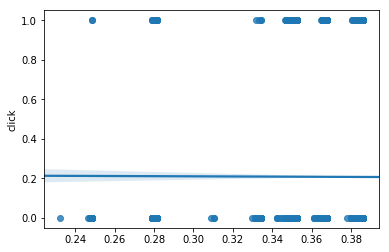

In [57]:
# plt.scatter(regressor.predict(test_csr),test_y)
sns.regplot(regressor.predict(test_csr),test_y)from sklearn import metrics

In [33]:
new_feature_train = lgb_clf.apply(train_csr)[:,-100:]   
# new_feature_val = lgb_clf.apply(val_csr)[:,-100:]
# new_feature_test = lgb_clf.apply(test_csr)[:,-100:]

AttributeError: 'LGBMClassifier' object has no attribute 'apply'